<a href="https://colab.research.google.com/github/shivendrra/SmallLanguageModel-project/blob/main/FullScaleSLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Full Scale Small Language Model
by @shivendrra

In [2]:
from google.colab import files
channelData = files.upload()

In [3]:
channel_Id_Json  = [
  "UCA19mAJURyYHbJzhfpqhpCA",
  "UCsXVk37bltHxD1rDPwtNM8Q",
  "UCRcgy6GzDeccI7dkbbBna3Q",
  "UCmGSJVG3mCRXVOP4yZrU1Dw",
  "UC415bOPUcGSamy543abLmRA",
  "UCb_MAhL8Thb3HJ_wPkH3gcw",
  "UC9RM-iSvTu1uPJb8X5yp3EQ",
  "UCR1IuLEqb6UEA_zQ81kwXfg",
  "UCYO_jab_esuFRV4b17AJtAw",
  "UCA295QVkf9O1RQ8_-s3FVXg",
  "UCqVEHtQoXHmUCfJ-9smpTSg",
  "UC4QZ_LsYcvcq7qOsOhpAX4A",
  "UCLXo7UDZvByw2ixzpQCufnA"
]

In [4]:
!pip install python-dotenv
!pip install youtube-transcript-api

In [5]:
import json
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv('yt_secret_key')

In [6]:
from googleapiclient.discovery import build
from youtube_transcript_api import TranscriptsDisabled, YouTubeTranscriptApi
import logging

logging.basicConfig(filename='youtube_fetch.log', level=logging.ERROR)
youtube = build('youtube', 'v3', developerKey=api_key)

In [7]:
import timeit

start_time = timeit.default_timer()

videoNo = 0
for links in channel_Id_Json:
  next_page_token = None
  videoIds = []

  while True:
    channelRes = youtube.channels().list(
      part='contentDetails', id=links
    ).execute()

    if 'items' in channelRes and channelRes['items']:
      playlistId = channelRes['items'][0]['contentDetails']['relatedPlaylists']['uploads']

      playlistResult = youtube.playlistItems().list(
        part='contentDetails', playlistId=playlistId,
        maxResults = 100, pageToken = next_page_token
      ).execute()

      videoIds.extend([item['contentDetails']['videoId'] for item in playlistResult.get('items', [])])

      next_page_token = playlistResult.get('nextPageToken')

      if not next_page_token:
        break

  for ids in videoIds:
    videoUrl = f"https://www.youtube.com/watch?v={ids}"
    try:
      raw_transcripts = []
      try:
        captions = YouTubeTranscriptApi.get_transcript(
          ids, languages=['en'], preserve_formatting=True
        )
        if captions:
          formatted_captions = [{'text': caption['text']} for caption in captions]
          raw_transcripts.append(formatted_captions)
          videoNo += 1
          print(f"Number of videos with valid captions are: {videoNo}")
        else:
          continue
      except TranscriptsDisabled as e:
        print(F"There was an error while getting the captions: {e}")
      except Exception as e:
        logging.error(f"There was some error while fetching the video: {str(e)}")
    except Exception as e:
      logging.error(f"There was some error while getting the captions: {str(e)}")

    with open('training_data.txt', 'a', encoding='utf-8') as file:
      for videoCaptions in raw_transcripts:
        for line in videoCaptions:
          file.write(line['text'] + ' ')

print(f"time taken to execute the code is {timeit.default_timer() - start_time} mins")

Number of videos with valid captions are: 1653
Number of videos with valid captions are: 1654
Number of videos with valid captions are: 1655
Number of videos with valid captions are: 1656
Number of videos with valid captions are: 1657
Number of videos with valid captions are: 1658
Number of videos with valid captions are: 1659
Number of videos with valid captions are: 1660
Number of videos with valid captions are: 1661
Number of videos with valid captions are: 1662
Number of videos with valid captions are: 1663
Number of videos with valid captions are: 1664
Number of videos with valid captions are: 1665
Number of videos with valid captions are: 1666
Number of videos with valid captions are: 1667
Number of videos with valid captions are: 1668
Number of videos with valid captions are: 1669


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=AQdrbepn3pE! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (AQdrbepn3pE) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-IE ("English (Ireland)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto")
 - 

Number of videos with valid captions are: 1670
Number of videos with valid captions are: 1671
Number of videos with valid captions are: 1672
Number of videos with valid captions are: 1673
Number of videos with valid captions are: 1674
Number of videos with valid captions are: 1675
Number of videos with valid captions are: 1676
Number of videos with valid captions are: 1677
Number of videos with valid captions are: 1678
Number of videos with valid captions are: 1679
Number of videos with valid captions are: 1680
Number of videos with valid captions are: 1681
Number of videos with valid captions are: 1682
Number of videos with valid captions are: 1683
Number of videos with valid captions are: 1684


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=yn9qhQSMCRk! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (yn9qhQSMCRk) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-GB ("English (United Kingdom)")[TRANSLATABLE]
 - fr ("French")[TRANSLATABLE]
 - it ("Italian")[TRANSLATABLE]
 - ru ("Russian")[TRANSLATABLE]
 - es ("Spanish")[TRANSLATABLE]

(GENERATED)
 - nl ("Dutch (auto-generated)")[TRANSLATABLE]

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-

Number of videos with valid captions are: 1685
Number of videos with valid captions are: 1686
Number of videos with valid captions are: 1687
Number of videos with valid captions are: 1688
Number of videos with valid captions are: 1689
Number of videos with valid captions are: 1690
Number of videos with valid captions are: 1691
Number of videos with valid captions are: 1692
Number of videos with valid captions are: 1693
Number of videos with valid captions are: 1694
Number of videos with valid captions are: 1695
Number of videos with valid captions are: 1696
Number of videos with valid captions are: 1697
Number of videos with valid captions are: 1698
Number of videos with valid captions are: 1699
Number of videos with valid captions are: 1700
Number of videos with valid captions are: 1701
Number of videos with valid captions are: 1702
Number of videos with valid captions are: 1703
Number of videos with valid captions are: 1704
Number of videos with valid captions are: 1705
Number of vid

ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=fJgC3PVhbJ8! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (fJgC3PVhbJ8) transcripts are available in the following languages:

(MANUALLY CREATED)
None

(GENERATED)
 - hi ("Hindi (auto-generated)")[TRANSLATABLE]

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto")
 

Number of videos with valid captions are: 1872
Number of videos with valid captions are: 1873
Number of videos with valid captions are: 1874
Number of videos with valid captions are: 1875
Number of videos with valid captions are: 1876
Number of videos with valid captions are: 1877
Number of videos with valid captions are: 1878
Number of videos with valid captions are: 1879
Number of videos with valid captions are: 1880
Number of videos with valid captions are: 1881
Number of videos with valid captions are: 1882
Number of videos with valid captions are: 1883
Number of videos with valid captions are: 1884
Number of videos with valid captions are: 1885
Number of videos with valid captions are: 1886
Number of videos with valid captions are: 1887
Number of videos with valid captions are: 1888
Number of videos with valid captions are: 1889
Number of videos with valid captions are: 1890
Number of videos with valid captions are: 1891
Number of videos with valid captions are: 1892
Number of vid

ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=GADqwNS7zds! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (GADqwNS7zds) transcripts are available in the following languages:

(MANUALLY CREATED)
None

(GENERATED)
 - hi ("Hindi (auto-generated)")[TRANSLATABLE]

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto")
 

Number of videos with valid captions are: 1979
Number of videos with valid captions are: 1980
Number of videos with valid captions are: 1981


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=VZLnXKPEaY8! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (VZLnXKPEaY8) transcripts are available in the following languages:

(MANUALLY CREATED)
None

(GENERATED)
 - hi ("Hindi (auto-generated)")[TRANSLATABLE]

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto")
 

Number of videos with valid captions are: 1982
Number of videos with valid captions are: 1983
Number of videos with valid captions are: 1984
Number of videos with valid captions are: 1985
Number of videos with valid captions are: 1986
Number of videos with valid captions are: 1987
Number of videos with valid captions are: 1988
Number of videos with valid captions are: 1989
Number of videos with valid captions are: 1990
Number of videos with valid captions are: 1991
Number of videos with valid captions are: 1992
Number of videos with valid captions are: 1993
Number of videos with valid captions are: 1994
Number of videos with valid captions are: 1995
Number of videos with valid captions are: 1996
Number of videos with valid captions are: 1997
Number of videos with valid captions are: 1998
Number of videos with valid captions are: 1999
Number of videos with valid captions are: 2000
Number of videos with valid captions are: 2001
Number of videos with valid captions are: 2002
Number of vid

ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=UpmwhkNg5Dw! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (UpmwhkNg5Dw) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]
 - es-419 ("Spanish (Latin America)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")

Number of videos with valid captions are: 2637
Number of videos with valid captions are: 2638
Number of videos with valid captions are: 2639
Number of videos with valid captions are: 2640
Number of videos with valid captions are: 2641
Number of videos with valid captions are: 2642
Number of videos with valid captions are: 2643
Number of videos with valid captions are: 2644
Number of videos with valid captions are: 2645
Number of videos with valid captions are: 2646


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=sxHu46YKnZg! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (sxHu46YKnZg) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]
 - es-419 ("Spanish (Latin America)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")

Number of videos with valid captions are: 2647
Number of videos with valid captions are: 2648
Number of videos with valid captions are: 2649
Number of videos with valid captions are: 2650
Number of videos with valid captions are: 2651
Number of videos with valid captions are: 2652
Number of videos with valid captions are: 2653
Number of videos with valid captions are: 2654
Number of videos with valid captions are: 2655
Number of videos with valid captions are: 2656
Number of videos with valid captions are: 2657
Number of videos with valid captions are: 2658
Number of videos with valid captions are: 2659
Number of videos with valid captions are: 2660
Number of videos with valid captions are: 2661
Number of videos with valid captions are: 2662
Number of videos with valid captions are: 2663
Number of videos with valid captions are: 2664
Number of videos with valid captions are: 2665
Number of videos with valid captions are: 2666
Number of videos with valid captions are: 2667
Number of vid

ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=riWh6Ljgu_M! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (riWh6Ljgu_M) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]
 - es-419 ("Spanish (Latin America)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")

Number of videos with valid captions are: 2680
Number of videos with valid captions are: 2681


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=_y_CCiwKzQw! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (_y_CCiwKzQw) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]
 - es-419 ("Spanish (Latin America)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")

Number of videos with valid captions are: 2682
Number of videos with valid captions are: 2683
Number of videos with valid captions are: 2684


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=ILaU78Oo7XM! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (ILaU78Oo7XM) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]
 - es-419 ("Spanish (Latin America)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")

Number of videos with valid captions are: 2685
Number of videos with valid captions are: 2686
Number of videos with valid captions are: 2687
Number of videos with valid captions are: 2688
Number of videos with valid captions are: 2689
Number of videos with valid captions are: 2690
Number of videos with valid captions are: 2691
Number of videos with valid captions are: 2692
Number of videos with valid captions are: 2693
Number of videos with valid captions are: 2694
Number of videos with valid captions are: 2695
Number of videos with valid captions are: 2696
Number of videos with valid captions are: 2697
Number of videos with valid captions are: 2698
Number of videos with valid captions are: 2699
Number of videos with valid captions are: 2700
Number of videos with valid captions are: 2701
Number of videos with valid captions are: 2702
Number of videos with valid captions are: 2703
Number of videos with valid captions are: 2704
Number of videos with valid captions are: 2705
Number of vid

ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=KBXMan0Dafw! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (KBXMan0Dafw) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]
 - es-419 ("Spanish (Latin America)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")

Number of videos with valid captions are: 2848
Number of videos with valid captions are: 2849
Number of videos with valid captions are: 2850
Number of videos with valid captions are: 2851
Number of videos with valid captions are: 2852
Number of videos with valid captions are: 2853
Number of videos with valid captions are: 2854


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=dphq5X-rMew! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (dphq5X-rMew) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]
 - es-419 ("Spanish (Latin America)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")

Number of videos with valid captions are: 2855
Number of videos with valid captions are: 2856
Number of videos with valid captions are: 2857
Number of videos with valid captions are: 2858
Number of videos with valid captions are: 2859
Number of videos with valid captions are: 2860
Number of videos with valid captions are: 2861
Number of videos with valid captions are: 2862
Number of videos with valid captions are: 2863
Number of videos with valid captions are: 2864
Number of videos with valid captions are: 2865
Number of videos with valid captions are: 2866
Number of videos with valid captions are: 2867
Number of videos with valid captions are: 2868
Number of videos with valid captions are: 2869
Number of videos with valid captions are: 2870
Number of videos with valid captions are: 2871
Number of videos with valid captions are: 2872
Number of videos with valid captions are: 2873
Number of videos with valid captions are: 2874
Number of videos with valid captions are: 2875
Number of vid

ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=waOUNwZA4aQ! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (waOUNwZA4aQ) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]
 - es-419 ("Spanish (Latin America)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")

Number of videos with valid captions are: 2894
Number of videos with valid captions are: 2895
Number of videos with valid captions are: 2896
Number of videos with valid captions are: 2897
Number of videos with valid captions are: 2898
Number of videos with valid captions are: 2899
Number of videos with valid captions are: 2900
Number of videos with valid captions are: 2901
Number of videos with valid captions are: 2902
Number of videos with valid captions are: 2903
There was an error while getting the captions: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=vVb43-3AT7s! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the

ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=xXpB9FNmEOs! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (xXpB9FNmEOs) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2928


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=fFy-muKWmQ8! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (fFy-muKWmQ8) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2929
Number of videos with valid captions are: 2930
Number of videos with valid captions are: 2931
Number of videos with valid captions are: 2932


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=0Flsg_mzG-M! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (0Flsg_mzG-M) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2933


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=OM-wpoe_bs8! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (OM-wpoe_bs8) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2934


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=8GqWTqDhahM! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (8GqWTqDhahM) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]
 - es-419 ("Spanish (Latin America)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")

Number of videos with valid captions are: 2935
Number of videos with valid captions are: 2936
Number of videos with valid captions are: 2937
Number of videos with valid captions are: 2938
Number of videos with valid captions are: 2939
Number of videos with valid captions are: 2940
Number of videos with valid captions are: 2941
Number of videos with valid captions are: 2942
Number of videos with valid captions are: 2943
Number of videos with valid captions are: 2944
Number of videos with valid captions are: 2945
Number of videos with valid captions are: 2946
Number of videos with valid captions are: 2947
Number of videos with valid captions are: 2948


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=EXF-9GtHsek! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (EXF-9GtHsek) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]
 - pt-BR ("Portuguese (Brazil)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - n

Number of videos with valid captions are: 2949


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=_g2CaF12xxw! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (_g2CaF12xxw) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2950


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=W1IYd5vJ6og! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (W1IYd5vJ6og) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2951


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=WMRip0eRER8! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (WMRip0eRER8) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]
 - es-419 ("Spanish (Latin America)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")

Number of videos with valid captions are: 2952
Number of videos with valid captions are: 2953


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=EiX3hTPGoCg! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (EiX3hTPGoCg) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2954


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=2ty2J0s2W0c! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (2ty2J0s2W0c) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2955
Number of videos with valid captions are: 2956


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=B1BdVnpaBtY! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (B1BdVnpaBtY) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2957


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=fgebKEYzgGg! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (fgebKEYzgGg) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2958
Number of videos with valid captions are: 2959
Number of videos with valid captions are: 2960
Number of videos with valid captions are: 2961
Number of videos with valid captions are: 2962


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=K3odScka55A! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (K3odScka55A) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]
 - hi ("Hindi")[TRANSLATABLE]
 - pt-BR ("Portuguese (Brazil)")[TRANSLATABLE]
 - es-419 ("Spanish (Latin America)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Co

Number of videos with valid captions are: 2963


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=vaNOuVgwPos! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (vaNOuVgwPos) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2964


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=34oI0yd5YUc! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (34oI0yd5YUc) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2965


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=LmiBASu41-A! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (LmiBASu41-A) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2966
Number of videos with valid captions are: 2967
Number of videos with valid captions are: 2968
Number of videos with valid captions are: 2969
Number of videos with valid captions are: 2970


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=KQyAnKjD6W4! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (KQyAnKjD6W4) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2971
Number of videos with valid captions are: 2972
Number of videos with valid captions are: 2973


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=ArffMWtdu-s! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (ArffMWtdu-s) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2974
Number of videos with valid captions are: 2975


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=IUEN2TAqlmU! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (IUEN2TAqlmU) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2976
Number of videos with valid captions are: 2977
Number of videos with valid captions are: 2978
Number of videos with valid captions are: 2979
Number of videos with valid captions are: 2980
Number of videos with valid captions are: 2981
Number of videos with valid captions are: 2982
Number of videos with valid captions are: 2983
Number of videos with valid captions are: 2984
Number of videos with valid captions are: 2985
Number of videos with valid captions are: 2986
Number of videos with valid captions are: 2987
Number of videos with valid captions are: 2988
Number of videos with valid captions are: 2989
Number of videos with valid captions are: 2990


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=P8QVBt2hh9M! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (P8QVBt2hh9M) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2991
Number of videos with valid captions are: 2992


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=4Rnb0j-bNmM! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (4Rnb0j-bNmM) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2993
Number of videos with valid captions are: 2994
Number of videos with valid captions are: 2995


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=F07yTI0J3Qk! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (F07yTI0J3Qk) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2996


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=xRnpUptf7E0! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (xRnpUptf7E0) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2997
Number of videos with valid captions are: 2998


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=-ZDZtBRTyeI! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (-ZDZtBRTyeI) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 2999
Number of videos with valid captions are: 3000


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=HuEyrLbJ25w! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (HuEyrLbJ25w) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 3001
Number of videos with valid captions are: 3002
Number of videos with valid captions are: 3003
Number of videos with valid captions are: 3004
Number of videos with valid captions are: 3005
Number of videos with valid captions are: 3006


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=jk1eTURC8sA! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (jk1eTURC8sA) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]
 - pt ("Portuguese")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")


Number of videos with valid captions are: 3007
Number of videos with valid captions are: 3008
Number of videos with valid captions are: 3009
Number of videos with valid captions are: 3010
Number of videos with valid captions are: 3011
Number of videos with valid captions are: 3012
Number of videos with valid captions are: 3013
Number of videos with valid captions are: 3014
Number of videos with valid captions are: 3015
Number of videos with valid captions are: 3016
Number of videos with valid captions are: 3017
Number of videos with valid captions are: 3018
Number of videos with valid captions are: 3019
Number of videos with valid captions are: 3020
Number of videos with valid captions are: 3021
Number of videos with valid captions are: 3022
Number of videos with valid captions are: 3023


ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=6IN4ZcZAUbA! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (6IN4ZcZAUbA) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]
 - es-419 ("Spanish (Latin America)")[TRANSLATABLE]

(GENERATED)
 - es ("Spanish (auto-generated)")[TRANSLATABLE]

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs

Number of videos with valid captions are: 3024
Number of videos with valid captions are: 3025
Number of videos with valid captions are: 3026
Number of videos with valid captions are: 3027
Number of videos with valid captions are: 3028
There was an error while getting the captions: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=0EIFDSb7tWc! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!
Number of videos with valid captions are: 3029
Number of videos with valid captions are: 3030
Number of videos with valid captions are: 3031
Numb

ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=HLxvq_M4218! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (HLxvq_M4218) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 3046
Number of videos with valid captions are: 3047
Number of videos with valid captions are: 3048
Number of videos with valid captions are: 3049
Number of videos with valid captions are: 3050
Number of videos with valid captions are: 3051
Number of videos with valid captions are: 3052
Number of videos with valid captions are: 3053
Number of videos with valid captions are: 3054
Number of videos with valid captions are: 3055
Number of videos with valid captions are: 3056
Number of videos with valid captions are: 3057
Number of videos with valid captions are: 3058
Number of videos with valid captions are: 3059
Number of videos with valid captions are: 3060
Number of videos with valid captions are: 3061
Number of videos with valid captions are: 3062
Number of videos with valid captions are: 3063
Number of videos with valid captions are: 3064
Number of videos with valid captions are: 3065
Number of videos with valid captions are: 3066
Number of vid

ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=gcHkxP9adiM! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (gcHkxP9adiM) transcripts are available in the following languages:

(MANUALLY CREATED)
 - ar ("Arabic")[TRANSLATABLE]
 - en-US ("English (United States)")[TRANSLATABLE]
 - uk ("Ukrainian")[TRANSLATABLE]
 - vi ("Vietnamese")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 

Number of videos with valid captions are: 3078
Number of videos with valid captions are: 3079
Number of videos with valid captions are: 3080
Number of videos with valid captions are: 3081
Number of videos with valid captions are: 3082
Number of videos with valid captions are: 3083
Number of videos with valid captions are: 3084
Number of videos with valid captions are: 3085
Number of videos with valid captions are: 3086
Number of videos with valid captions are: 3087
Number of videos with valid captions are: 3088
Number of videos with valid captions are: 3089
Number of videos with valid captions are: 3090
Number of videos with valid captions are: 3091
Number of videos with valid captions are: 3092
There was an error while getting the captions: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=qtzvIBAYP_8! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a

ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=5Ci5XTpPq94! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (5Ci5XTpPq94) transcripts are available in the following languages:

(MANUALLY CREATED)
 - en-US ("English (United States)")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto

Number of videos with valid captions are: 3164
Number of videos with valid captions are: 3165
Number of videos with valid captions are: 3166
Number of videos with valid captions are: 3167
Number of videos with valid captions are: 3168
Number of videos with valid captions are: 3169
Number of videos with valid captions are: 3170
Number of videos with valid captions are: 3171
Number of videos with valid captions are: 3172
Number of videos with valid captions are: 3173
Number of videos with valid captions are: 3174
Number of videos with valid captions are: 3175
There was an error while getting the captions: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=rI_Iy1FoSn4! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which versi

ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=tC0IMn8lsdc! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (tC0IMn8lsdc) transcripts are available in the following languages:

(MANUALLY CREATED)
None

(GENERATED)
 - es ("Spanish (auto-generated)")[TRANSLATABLE]

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto")

Number of videos with valid captions are: 3428
Number of videos with valid captions are: 3429
Number of videos with valid captions are: 3430
Number of videos with valid captions are: 3431
Number of videos with valid captions are: 3432
Number of videos with valid captions are: 3433
Number of videos with valid captions are: 3434
Number of videos with valid captions are: 3435
Number of videos with valid captions are: 3436
Number of videos with valid captions are: 3437
Number of videos with valid captions are: 3438
Number of videos with valid captions are: 3439
Number of videos with valid captions are: 3440
Number of videos with valid captions are: 3441
Number of videos with valid captions are: 3442
Number of videos with valid captions are: 3443
Number of videos with valid captions are: 3444
Number of videos with valid captions are: 3445
Number of videos with valid captions are: 3446
Number of videos with valid captions are: 3447
Number of videos with valid captions are: 3448
Number of vid

ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=kRjSU8NUwVo! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (kRjSU8NUwVo) transcripts are available in the following languages:

(MANUALLY CREATED)
 - fr ("French")[TRANSLATABLE]

(GENERATED)
 - fr ("French (auto-generated)")[TRANSLATABLE]

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("Engl

Number of videos with valid captions are: 3939
Number of videos with valid captions are: 3940
There was an error while getting the captions: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=Bn6hVIISA6o! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!
Number of videos with valid captions are: 3941
There was an error while getting the captions: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=dDdzJFLw9yw! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the desc

ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=YR5M5A40sxc! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (YR5M5A40sxc) transcripts are available in the following languages:

(MANUALLY CREATED)
 - id ("Indonesian")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto")
 - et ("Eston

There was an error while getting the captions: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=NAN1kt4SG9E! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!
Number of videos with valid captions are: 3946
There was an error while getting the captions: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=v-prU9JmJEk! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, ple

ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=MNQ9z_Eb-Jc! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (MNQ9z_Eb-Jc) transcripts are available in the following languages:

(MANUALLY CREATED)
 - hu ("Hungarian")[TRANSLATABLE]

(GENERATED)
None

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("English")
 - eo ("Esperanto")
 - et ("Estoni

Number of videos with valid captions are: 4021
Number of videos with valid captions are: 4022
Number of videos with valid captions are: 4023
Number of videos with valid captions are: 4024
Number of videos with valid captions are: 4025
Number of videos with valid captions are: 4026
Number of videos with valid captions are: 4027
Number of videos with valid captions are: 4028
Number of videos with valid captions are: 4029
There was an error while getting the captions: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=fSp6f-t-Rss! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open i

ERROR:root:There was some error while fetching the video: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=cMgarcFkXz4! This is most likely caused by:

No transcripts were found for any of the requested language codes: ['en']

For this video (cMgarcFkXz4) transcripts are available in the following languages:

(MANUALLY CREATED)
 - de ("German")[TRANSLATABLE]

(GENERATED)
 - ko ("Korean (auto-generated)")[TRANSLATABLE]

(TRANSLATION LANGUAGES)
 - af ("Afrikaans")
 - ak ("Akan")
 - sq ("Albanian")
 - am ("Amharic")
 - ar ("Arabic")
 - hy ("Armenian")
 - as ("Assamese")
 - ay ("Aymara")
 - az ("Azerbaijani")
 - bn ("Bangla")
 - eu ("Basque")
 - be ("Belarusian")
 - bho ("Bhojpuri")
 - bs ("Bosnian")
 - bg ("Bulgarian")
 - my ("Burmese")
 - ca ("Catalan")
 - ceb ("Cebuano")
 - zh-Hans ("Chinese (Simplified)")
 - zh-Hant ("Chinese (Traditional)")
 - co ("Corsican")
 - hr ("Croatian")
 - cs ("Czech")
 - da ("Danish")
 - dv ("Divehi")
 - nl ("Dutch")
 - en ("Engl

Number of videos with valid captions are: 4071
Number of videos with valid captions are: 4072
Number of videos with valid captions are: 4073
Number of videos with valid captions are: 4074
Number of videos with valid captions are: 4075
Number of videos with valid captions are: 4076
Number of videos with valid captions are: 4077
Number of videos with valid captions are: 4078
Number of videos with valid captions are: 4079
There was an error while getting the captions: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=OFJrow7yaec! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open i

In [8]:
with open('training_data.txt', 'r', encoding='utf-8') as file:
  captions = file.read()

In [9]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, PorterStemmer
ps = PorterStemmer()
lm = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
tokens = nltk.word_tokenize(captions)
lm = WordNetLemmatizer()
lemmatized_tokens = [lm.lemmatize(token.lower()) for token in tokens if token.isalpha()]

In [11]:
# Convert lemmatized tokens back to text
lemmatized_text = ' '.join(lemmatized_tokens)

In [12]:
# Applying tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform([lemmatized_text]).toarray()

In [13]:
# converting the vectors to .csv and then saving it
import pandas as pd

vector_array = pd.DataFrame(tfidf_matrix)
vector_array.to_csv('vector_data.csv')

print('data written to .csv file successfully!!')
print(f"Data vectorized in : {timeit.default_timer() - start_time} mins")

data written to .csv file successfully!!
Data vectorized in : 4682.537818879 mins


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import time

start_time = time.time()
# Define CustomDataset
class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'input': torch.FloatTensor(self.data.iloc[idx, :-1].values),
                  'target': torch.FloatTensor([self.data.iloc[idx, -1]])}
        return sample

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, d_model=64, nhead=2, num_layers=2):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_layers)
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.embedding(x)

        # Reshape x to have shape (sequence_length, batch_size, d_model)
        x = x.unsqueeze(0)  # Add a sequence dimension at the beginning

        # Apply transformer
        x = self.transformer(x, x)

        # Remove the sequence dimension
        x = x.squeeze(0)

        # Average over the sequence dimension
        x = torch.mean(x, dim=0)

        # Pass through the fully connected layer
        x = self.fc(x)
        return x

# Initialize dataset and DataLoader
dataset = CustomDataset('vector_data.csv')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model
input_size = dataset[0]['input'].shape[0]
output_size = dataset[0]['target'].shape[0]
model = TransformerModel(input_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
losses = []  # List to store the losses

for epoch in range(num_epochs):
    epoch_losses = []  # List to store the losses for each epoch

    for batch in dataloader:
        inputs, targets = batch['input'], batch['target']

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    average_epoch_loss = np.mean(epoch_losses)
    losses.append(average_epoch_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_epoch_loss}')

end_time = start_time - time.time()
print('\n', f"Code executed in {end_time / 60} mins")
# Save the trained model
torch.save(model.state_dict(), 'transformer_model.pth')

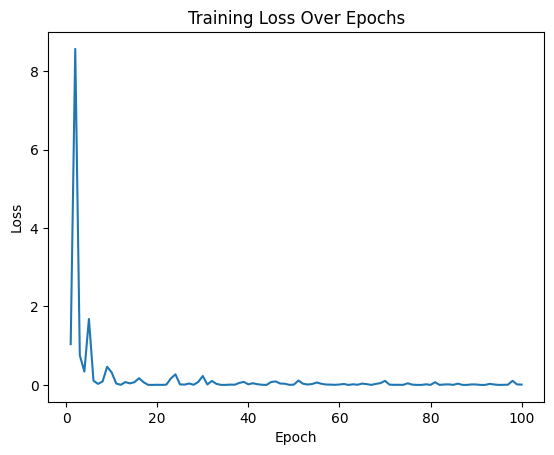

In [17]:
import matplotlib.pyplot as plt
# Visualize training loss
plt.plot(range(1, num_epochs + 1), losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(False)
plt.show()